In [1]:
from IPython.display import set_matplotlib_formats
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
from jax import random, vmap
import jax.numpy as jnp
import seaborn as sns
import pandas as pd
import numpy as np
import os

NAX = np.newaxis

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SA, HMC
from numpyro.infer import init_to_sample, init_to_value
from numpyro import handlers

plt.style.use('bmh')
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats('svg')

#assert numpyro.__version__.startswith('0.6.0')
#numpyro.set_platform("gpu")

numpyro.set_platform("cpu")
#numpyro.set_host_device_count(5)

from scipy.integrate import simps
from jax.numpy import trapz

In [2]:
cd ..

/mnt/disk2/samarth/qdpy-numpyro


In [3]:
cd qdpy_jax

/mnt/disk2/samarth/qdpy-numpyro/qdpy_jax


In [4]:
run rotation_kernels.py

[compute_Tsr] Time taken per iteration in seconds (no jax): , 5.301e-02 seconds
[get_Cvec] Time taken per iteration in seconds (no jax): , 7.041e-01 seconds


### Creating a simple qdPy script to test out pyro

In [5]:
def eig_mcmc_func(w1=None, w3=None, w5=None):
    return  get_eigs(create_supermatrix(w1, w3, w5))/2./omega0
    

#def create_supermatrix(wsr_slope):
def create_supermatrix(w1, w3, w5):
    integrand1 = 0.1*Tsr[0, :] * (1 + w1)
    integrand3 = 0.1*Tsr[1, :] * (1 + w3)
    integrand5 = 0.1*Tsr[2, :] * (1 + w5)
    integral1 = trapz(integrand1, x=r)
    integral3 = trapz(integrand3, x=r)
    integral5 = trapz(integrand5, x=r)
    prod_gamma1 = gamma(ell1)*gamma(ell2)*gamma(s_arr[0])
    prod_gamma3 = gamma(ell1)*gamma(ell2)*gamma(s_arr[0])
    prod_gamma5 = gamma(ell1)*gamma(ell2)*gamma(s_arr[0])
    wpi = (wigvals[:, 0]*integral1*prod_gamma1 + 
           wigvals[:, 1]*integral3*prod_gamma3 +
           wigvals[:, 2]*integral5*prod_gamma5)
    #diag = minus1pow_vecm(m)*8*np.pi*omega0*(wigvals @ (prod_gammas * integral))
    #diag = minus1pow_vecm(m)*8*np.pi*omega0*wpi
    diag = 8*np.pi*omega0*wpi
    supmat = jnp.diag(diag)
    return supmat

def get_eigs(mat):
    eigvals, eigvecs = jnp.linalg.eigh(mat)
    return eigvals

def gamma(ell):
    return jnp.sqrt((2*ell+1)/4./np.pi)

def minus1pow_vecm(num):
    modval = num % 2
    retval = np.zeros_like(modval)
    retval[modval == 1] = -1
    retval[modval == 0] = 1
    return retval

In [6]:
np.save("/mnt/disk2/samarth/qdpy-numpyro/qdpy_jax/Tsr.npy", Tsr)

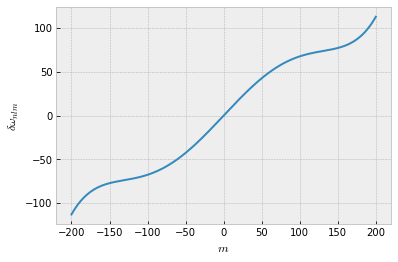

In [7]:
r = np.loadtxt('/mnt/disk2/samarth/qdpy-numpyro/qdpy_jax/r.dat')
U = np.loadtxt('/mnt/disk2/samarth/qdpy-numpyro/qdpy_jax/U3672.dat')
V = np.loadtxt('/mnt/disk2/samarth/qdpy-numpyro/qdpy_jax/V3672.dat')

rmin, rmax = 0.3, 1.0
rmin_idx = np.argmin(abs(r - rmin))
rmax_idx = np.argmin(abs(r - rmax)) + 1

r = r[rmin_idx:rmax_idx]
U = U[rmin_idx:rmax_idx]
V = V[rmin_idx:rmax_idx]

r = jnp.asarray(r)
U = jnp.asarray(U)
V = jnp.asarray(V)
Tsr = jnp.asarray(Tsr)

n1, n2 = 0, 0
ell1, ell2 = 200, 200
ell = min(ell1, ell2)
nu0 = 4741.

Msol = 1.989e33
Rsol = 6.956e10
B0 = 10.e5
OM = jnp.sqrt(4*np.pi*Rsol*B0**2/Msol)
nu0 /= OM*1e6
omega0 = 2*jnp.pi*nu0

s_arr = jnp.array([1., 3., 5.])
m = jnp.arange(-ell, ell+1)
wigvals = np.zeros((2*ell+1, len(s_arr)))
for i in range(len(s_arr)):
    wigvals[:, i] = w3j_vecm(ell1, s_arr[i], ell2, -m, 0*m, m)
    
wigvals = jnp.asarray(wigvals)
w1t, w3t, w5t = 10.51, .43, .175
eigvals_true = get_eigs(create_supermatrix(w1t, w3t, w5t))/2/omega0
eigvals_sigma = np.ones_like(eigvals_true)*0.015
eigvals_sigma = jnp.asarray(eigvals_sigma)

plt.figure()
plt.plot(m, eigvals_true)
plt.xlabel('$m$')
plt.ylabel('$\delta\omega_{nlm}$')
plt.show()



In [8]:
def model():
    # setting min and max value to be 0.1*true and 3.*true
    w1min, w1max = -.1*abs(w1t), 3.*abs(w1t)
    w3min, w3max = -.1*abs(w3t), 3.*abs(w3t)
    w5min, w5max = -.1*abs(w5t), 3.*abs(w5t)
    
    w1 = numpyro.sample('w1', dist.Uniform(w1min, w1max))
    w3 = numpyro.sample('w3', dist.Uniform(w3min, w3max))
    w5 = numpyro.sample('w5', dist.Uniform(w5min, w5max))
    
    #eig_sample = numpyro.deterministic('eig', eig_mcmc_func(w1=w1, w3=w3, w5=w5))
    # eig_sample = eig_mcmc_func(w1=w1, w3=w3, w5=w5)
    # numpyro.factor('obs', dist.Normal(eig_sample, eigvals_sigma).log_prob(eigvals_true))
    eig_sample = eig_mcmc_func(w1=w1, w3=w3, w5=w5)
    eig_sample -= eigvals_true
    eig_sample /= eigvals_sigma
    numpyro.factor('obs', dist.Normal(0.0, 1.0).log_prob(eig_sample))
    #numpyro.sample('obs', dist.Normal(eig_sample, eigvals_sigma), obs=eigvals_true)
    return None

In [23]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(int(15 + 10*np.random.rand()))
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
#kernel = NUTS(model, adapt_step_size=True)
#mcmc = MCMC(kernel, num_warmup=10, num_samples=20, num_chains=1)
#kernel = HMC(model)

kernel = SA(model, adapt_state_size=130)
mcmc = MCMC(kernel, num_warmup=3499, num_samples=4, num_chains=1, progress_bar=False)

model_init = numpyro.infer.util.initialize_model(rng_key_, model, model_args=())


In [24]:
mcmc.run(rng_key_, extra_fields=('potential_energy',))
#mcmc.run(rng_key_, x_scaled=x_scaled)
mcmc.print_summary()
print(f"w1_true = {w1t}\n" +
      f"w3_true = {w3t}\n" +
      f"w5_true = {w5t}")

mcmc.post_warmup_state = mcmc.last_state

import pickle
with open('mcmc_warmup.pkl', 'wb') as f:
    pickle.dump(mcmc, f)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        w1     10.47      0.00     10.47     10.47     10.47      2.71      4.56
        w3      0.55      0.00      0.55      0.55      0.55      5.34      0.92
        w5      0.31      0.00      0.31      0.31      0.31      3.61      1.18

Number of divergences: 0
w1_true = 10.51
w3_true = 0.43
w5_true = 0.175


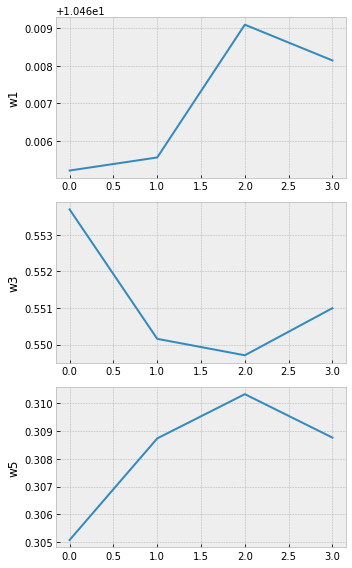

In [26]:
samples_1 = mcmc.get_samples()
fig, axs = plt.subplots(nrows=len(samples_1.keys()), ncols=1, figsize=(5, 8))
axs = axs.flatten()
count = 0
for key in samples_1.keys():
    axs[count].plot(samples_1[f'{key}'])
    axs[count].set_ylabel(f'{key}')
    count += 1
plt.tight_layout()

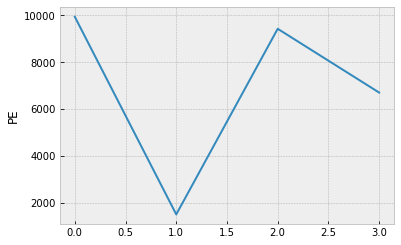

In [20]:
pe = mcmc.get_extra_fields()['potential_energy']
plt.figure()
plt.plot(pe)
plt.ylabel('PE')
plt.show()

In [ ]:
import arviz as az
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True);

In [ ]:
eig_samples = samples_1['eig']

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axs = axs.flatten()
for i in range(eig_samples.shape[0]):
    axs[0].plot(m, eig_samples[i, :], 'r', alpha=0.02)
    axs[1].plot(m, eig_samples[i, :] - eigvals_true, 'r', alpha=0.02)
axs[0].plot(m, eig_samples[-1, :], 'r', label='model')
axs[0].plot(m, eigvals_true, '--k', label='observed')


axs[0].set_xlabel('$m$')
axs[0].set_ylabel('$\delta\omega_{nlm}$')
axs[1].set_ylabel('Model($\delta\omega_{nlm}$) - Data($\delta\omega_{nlm}$)')
axs[1].set_xlabel('$m$')
axs[0].legend()
plt.show()

In [27]:
kernel = SA(model, adapt_state_size=130)
mcmc2 = MCMC(kernel, num_warmup=1, num_samples=4, num_chains=1, progress_bar=False)
mcmc2.run(rng_key_, extra_fields=('potential_energy',))


def new_run(mcmc, keyval, num_join):
    key = random.PRNGKey(keyval)
    print(f"key = {key}")
    samples = jnp.array([])
    with open('mcmc_warmup.pkl', 'rb') as f:
        loaded_mcmc = pickle.load(f)
    mcmc2.num_samples = 1500
    mcmc2._warmup_state = loaded_mcmc._warmup_state
    mcmc2.progress_bar = True
    for i in range(num_join):
        mcmc2.run(key)
        samples = jnp.append(samples, mcmc2.get_samples()['w1'])
    return samples
    

samples1 = new_run(mcmc, 1, 1)
samples2 = new_run(mcmc, 2, 1)
samples3 = new_run(mcmc, 3, 1)

key = [0 1]


sample: 100%|██████████| 1500/1500 [00:07<00:00, 201.73it/s, acc. prob=0.95]


key = [0 2]


sample: 100%|██████████| 1500/1500 [00:03<00:00, 463.28it/s, acc. prob=0.95]


key = [0 3]


sample: 100%|██████████| 1500/1500 [00:03<00:00, 463.18it/s, acc. prob=0.95]


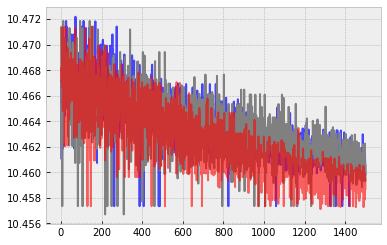

In [28]:
plt.figure()
plt.plot(samples2, 'b', alpha=0.7)
plt.plot(samples3, 'gray')
plt.plot(samples1, 'r', alpha=0.6)
plt.show()

In [ ]:
samples1['w1'].shape

In [ ]:
mcmc.progress_bar

In [ ]:
?mcmc.warmup